# Bio-optical Backscattering (BBP) Data Explorer

## This notebook processes and visualizes bio-optical data, specifically backscattering coefficients (bbp), typically derived from oceanographic sensors or satellite data.

### Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import glob

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

### Load and Prepare Data
### We load the dataset and ensure the temporal and spatial columns are correctly formatted python objects.

In [2]:
# Define the directory containing the BBP files
# os.path.expanduser('~') handles the home directory correctly on Mac/Linux
bbp_dir = os.path.expanduser('~/sedtrap_bbp/data_gom')

# Find all TSV files starting with 'bbp_'
# We use os.path.join for cross-platform compatibility
search_pattern = os.path.join(bbp_dir, 'bbp_*.tsv')
bbp_files = glob.glob(search_pattern)

# Diagnostic Print: If you see 0 files, check if the path printed below is correct
print(f"Searching in: {search_pattern}")
print(f"Files found: {len(bbp_files)}")

# Initialize an empty list to store DataFrames
dfs = []

try:
    # Loop through each file and read it
    for file in bbp_files:
        # Read the TSV file (tab-separated)
        temp_df = pd.read_csv(file, sep='\t')
        dfs.append(temp_df)
    
    # Concatenate all DataFrames into one
    if dfs:
        data = pd.concat(dfs, ignore_index=True)
        
        # Ensure the 'datetime' column is converted to datetime objects
        if 'datetime' in data.columns:
            data['date'] = pd.to_datetime(data['datetime'])
            # Sort the table by datetime ascending
            data = data.sort_values('date').reset_index(drop=True)
        
        print(f"Successfully merged {len(bbp_files)} files.")
        print(f"Total rows in dataset: {len(data)}")
        print(data.head())
    else:
        print("--- ERROR: No matching BBP files found ---")
        print(f"Please verify that the folder '{bbp_dir}' exists and contains .tsv files starting with 'bbp_'.")
        data = pd.DataFrame()

except Exception as e:
    print(f"Error processing files: {e}")


Searching in: /home/enrique.montes@CNS.local/sedtrap_bbp/data_gom/bbp_*.tsv
Files found: 4
Successfully merged 4 files.
Total rows in dataset: 240085
               datetime  bbp_532nm  bbp_700nm                date
0  01-Dec-2022 01:04:55   0.000758   0.000117 2022-12-01 01:04:55
1  01-Dec-2022 01:04:57   0.000902   0.000096 2022-12-01 01:04:57
2  01-Dec-2022 01:04:58   0.000614   0.000075 2022-12-01 01:04:58
3  01-Dec-2022 01:04:59   0.000854   0.000283 2022-12-01 01:04:59
4  01-Dec-2022 01:05:00   0.000710  -0.000008 2022-12-01 01:05:00


### Data Cleaning and Pre-processing
### Handle missing values (NaNs) and filter the data for valid ranges of backscattering coefficients (e.g., bbp > 0).

In [3]:
# --- 1. Check for Duplicate Rows (based on datetime) ---
# This replicates the MATLAB logic: reporting all duplicates and then keeping only unique entries.
if not data.empty:
    # Find all rows that are part of a duplicate set
    # keep=False marks ALL occurrences of a duplicate as True
    duplicate_mask = data.duplicated(subset=['date'], keep=False)
    duplicate_indices = data.index[duplicate_mask].tolist()

    if duplicate_indices:
        print(f"Found {len(duplicate_indices)} total rows that are part of a duplicate set.")
        print(f"The indices of these rows are: {duplicate_indices}")
        
        # Create a new DataFrame containing only the unique rows
        # keep='first' keeps the first occurrence and drops subsequent duplicates
        # This matches MATLAB's [~, unique_indices] = unique(bbp_tbl_raw.datetime)
        data_clean = data.drop_duplicates(subset=['date'], keep='first').reset_index(drop=True)
        
        print(f"The table 'data' had {len(data)} rows.")
        print(f"The table 'data_clean' has {len(data_clean)} rows.")
        data = data_clean
    else:
        print("No duplicate rows based on datetime were found.")

# --- 2. Drop rows missing essential temporal information ---
if not data.empty:
    initial_count = len(data)
    data = data.dropna(subset=['date'])
    if initial_count > len(data):
        print(f"Dropped {initial_count - len(data)} rows with missing dates after cleaning.")

# --- 3. Filter for valid BBP values ---
# Adjust 'bbp_700nm' to match the column name in your merged data
bbp_col = 'bbp_700nm' 
if not data.empty and bbp_col in data.columns:
    valid_mask = data[bbp_col] > 0
    data = data[valid_mask]
    print(f"Final filtered data contains {len(data)} valid records (bbp > 0).")

No duplicate rows based on datetime were found.
Final filtered data contains 191642 valid records (bbp > 0).


### BBP Time Series Visualization.
### Visualize how BBP changes over time. This helps in identifying seasonal cycles or specific events.

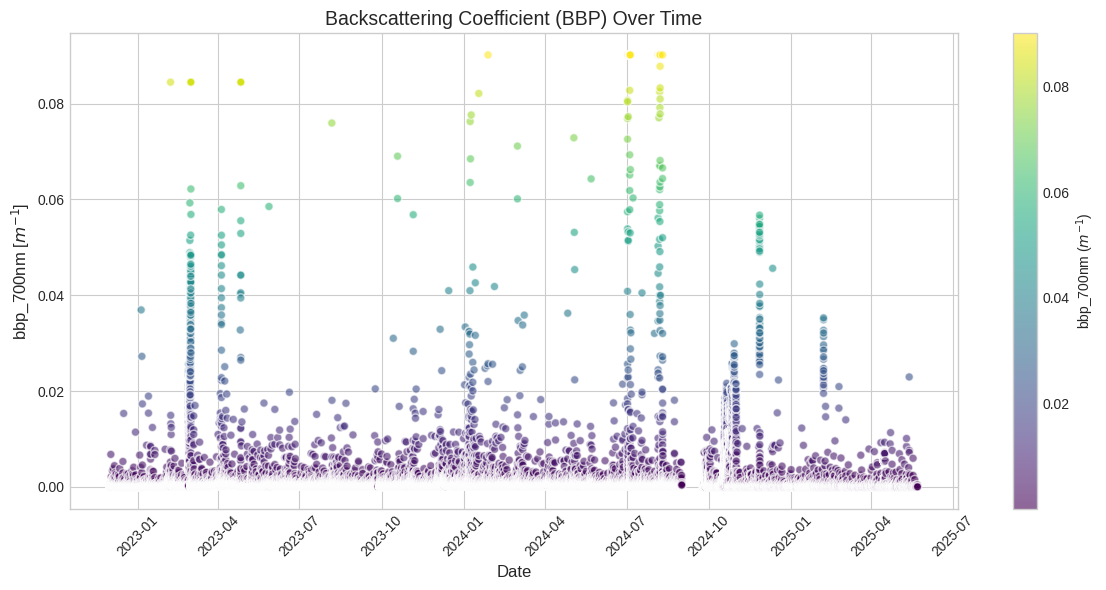

In [4]:
plt.figure(figsize=(12, 6))

# Plotting BBP vs Date
plt.scatter(data['date'], data[bbp_col], c=data[bbp_col], cmap='viridis', alpha=0.6, edgecolors='w')
plt.colorbar(label=f'{bbp_col} ($m^{{-1}}$)')

plt.title('Backscattering Coefficient (BBP) Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel(f'{bbp_col} [$m^{{-1}}$]', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Summary Statistics
### Calculate group statistics (e.g., monthly means) to identify trends.

In [5]:
# Create a Month-Year column for grouping
data['month_year'] = data['date'].dt.to_period('M')

monthly_summary = data.groupby('month_year')[bbp_col].agg(['mean', 'std', 'count']).reset_index()
monthly_summary['month_year'] = monthly_summary['month_year'].astype(str)

print("Monthly Summary Statistics:")
print(monthly_summary)

Monthly Summary Statistics:
   month_year      mean       std  count
0     2022-12  0.000161  0.000285   9897
1     2023-01  0.000199  0.000629   9918
2     2023-02  0.001417  0.004419   8960
3     2023-03  0.001114  0.005829   9920
4     2023-04  0.000930  0.004578   9600
5     2023-05  0.000294  0.000757   9780
6     2023-06  0.000467  0.000506   9600
7     2023-07  0.000375  0.000325   9920
8     2023-08  0.000422  0.000920   9920
9     2023-09  0.000337  0.000368   8845
10    2023-10  0.000399  0.001035   9920
11    2023-11  0.000417  0.000885   9485
12    2023-12  0.000588  0.000973   7440
13    2024-01  0.000642  0.002892   7440
14    2024-02  0.000479  0.001385   6960
15    2024-03  0.000431  0.000995   7440
16    2024-04  0.000485  0.000664   7200
17    2024-05  0.000495  0.001485   7440
18    2024-06  0.000375  0.000573   7200
19    2024-07  0.001339  0.008510   7440
20    2024-08  0.000886  0.005614   7380
21    2024-09  0.001094  0.001161    607
22    2024-10  0.003799  0.00

### Load and filter sediment trap data


In [6]:
# --- Load Sediment Trap Flux Data ---
try:
    trap_flux_tbl = pd.read_csv('~/sedtrap_bbp/data_gom/trap_flux_gom.csv')
    
    # Ensure Mid_Date is in datetime format
    if 'Mid_Date' in trap_flux_tbl.columns:
        trap_flux_tbl['Mid_Date'] = pd.to_datetime(trap_flux_tbl['Mid_Date'])
        
        # --- Filter by Date ---
        cutoff_date = pd.Timestamp(2022, 12, 1)
        initial_count = len(trap_flux_tbl)
        trap_flux_tbl = trap_flux_tbl[trap_flux_tbl['Mid_Date'] >= cutoff_date].reset_index(drop=True)
        
        print(f"Loaded trap flux data. Excluded {initial_count - len(trap_flux_tbl)} rows before {cutoff_date.date()}.")
        print(f"Remaining rows: {len(trap_flux_tbl)}")
    
    # --- Display Results ---
    print("\nFirst 10 rows of the filtered trap flux table:")
    print(trap_flux_tbl.head(10))

except Exception as e:
    print(f"Error loading sediment trap data: {e}")



First 10 rows of the filtered trap flux table:
   Cup  Duration        Date    Mid-Date  Julian Day  Mid-Julian  \
0    1         7  2021-12-07  2021-12-10        5090      5093.5   
1    2         7  2021-12-14  2021-12-17        5097      5100.5   
2    3        14  2021-12-21  2021-12-28        5104      5111.0   
3    4        14  2022-01-04  2022-01-11        5118      5125.0   
4    5        14  2022-01-18  2022-01-25        5132      5139.0   
5    6        14  2022-02-01  2022-02-08        5146      5153.0   
6    7        14  2022-02-15  2022-02-22        5160      5167.0   
7    8        14  2022-03-01  2022-03-08        5174      5181.0   
8    9        14  2022-03-15  2022-03-22        5188      5195.0   
9   10        14  2022-03-29  2022-04-05        5202      5209.0   

   tot_mass_flux  org_c_flux  caco3_flux  opal_flux  terr_flux  nitro_flux  
0        261.257       7.366      33.192     16.989    192.661       1.010  
1        867.543      17.287      89.946     48.0

### Plot trap data

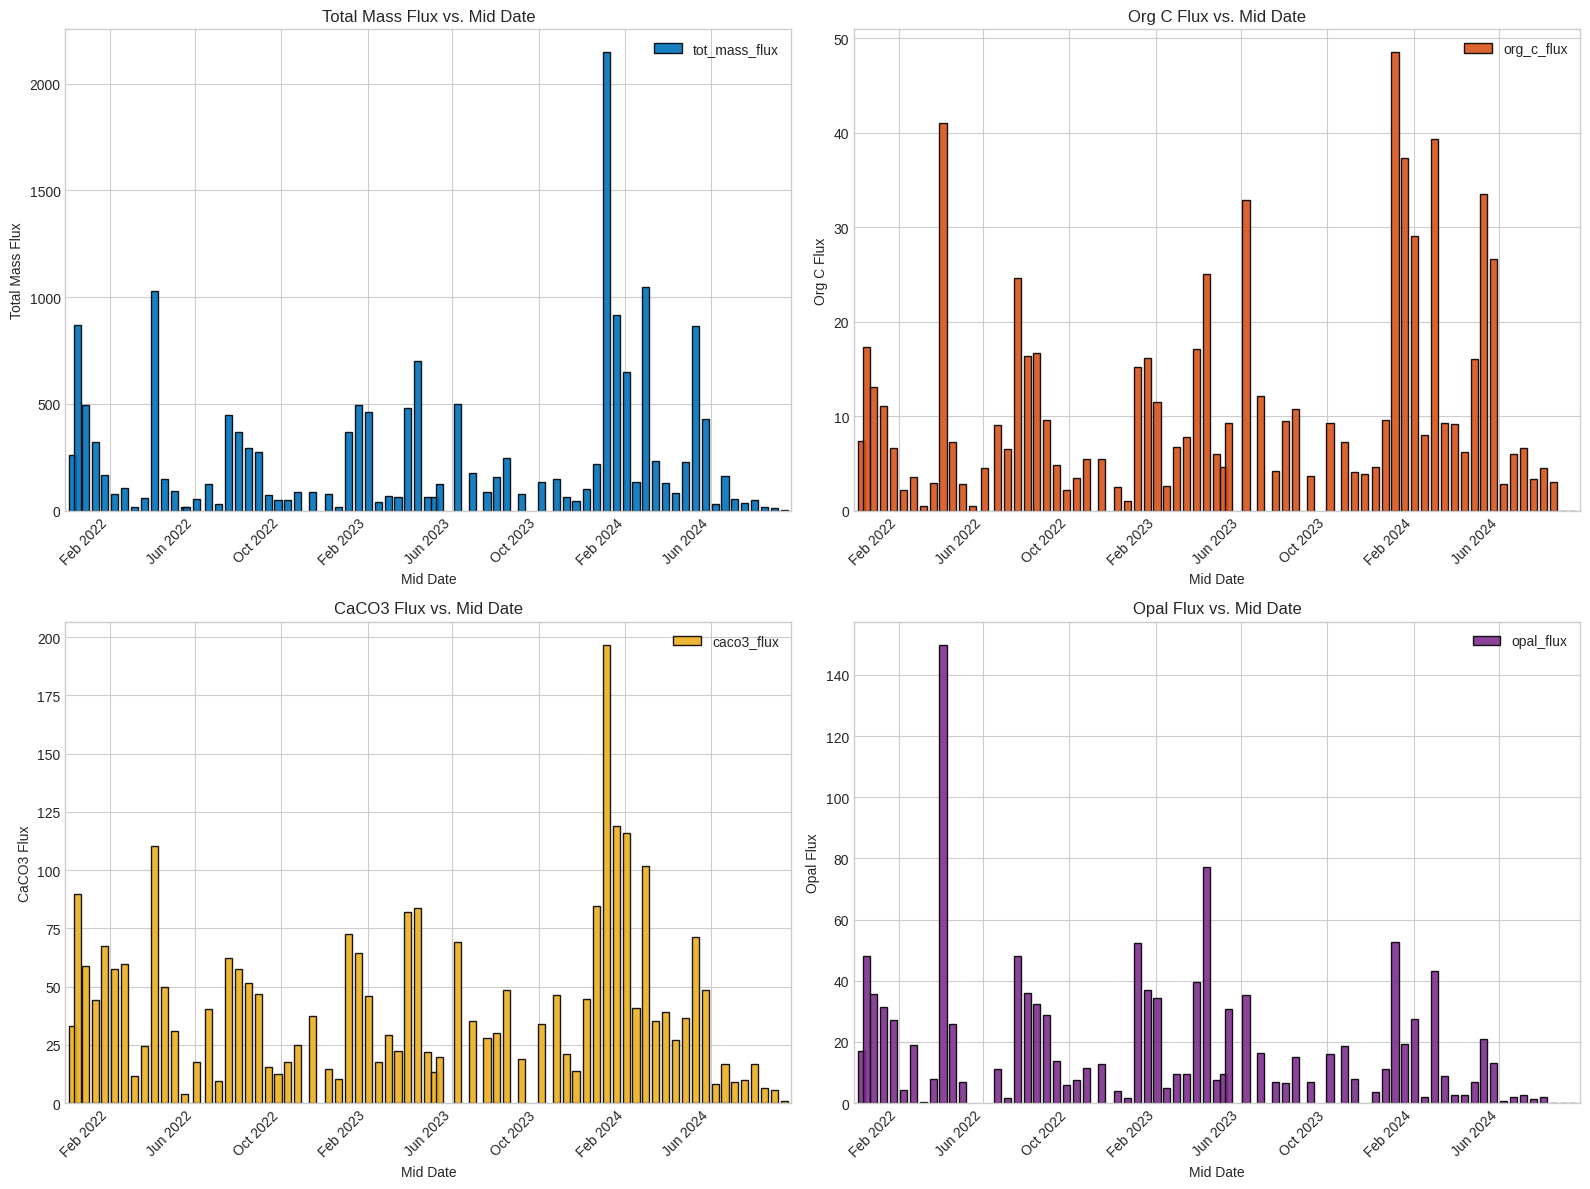

In [7]:
if 'trap_flux_tbl' in locals() and not trap_flux_tbl.empty and 'Mid-Date' in trap_flux_tbl.columns:
    import matplotlib.dates as mdates
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    colors = {
        'blue': [0, 0.4470, 0.7410],
        'red': [0.8500, 0.3250, 0.0980],
        'yellow': [0.9290, 0.6940, 0.1250],
        'purple': [0.4940, 0.1840, 0.5560]
    }

    plot_items = [
        ('tot_mass_flux', "Total Mass Flux", colors['blue']),
        ('org_c_flux', "Org C Flux", colors['red']),
        ('caco3_flux', "CaCO3 Flux", colors['yellow']),
        ('opal_flux', "Opal Flux", colors['purple'])
    ]

    for ax, (col, ylabel, color) in zip(axes.flatten(), plot_items):
        if col in trap_flux_tbl.columns:
            # We explicitly convert the datetime to matplotlib date numbers
            # This ensures the year is calculated correctly from the data
            x_values = mdates.date2num(trap_flux_tbl['Mid-Date'])
            
            # width=1.0 represents 1 full day
            ax.bar(x_values, trap_flux_tbl[col], 
                   label=col, color=color, width=10, align='center', edgecolor='black', alpha=0.9)
            
            # Formatting X-axis: Month Year (e.g., Jan 2023)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y')) 
            
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
            
            ax.set_xlabel("Mid Date")
            ax.set_ylabel(ylabel)
            ax.set_title(f"{ylabel} vs. Mid Date")
            ax.legend()
            
            # Explicitly set the limits based on the data to avoid 1970 fallback
            ax.set_xlim(x_values.min() - 10, x_values.max() + 10)
        else:
            ax.set_title(f"Column '{col}' missing")

    plt.tight_layout()
    plt.show()
else:
    print("Trap flux data or 'Mid-Date' column not available for plotting.")

### Bbp Outlier Removal for Baseline Modeling

In [8]:
# --- Outlier Removal via Quantiles ---
if not data.empty and bbp_col in data.columns:
    print(f"Performing outlier removal for {bbp_col} baseline...")
    
    # R: hi <- quantile(bbp_1500$BBP, 0.85, na.rm = TRUE)
    hi = data[bbp_col].quantile(0.85)
    
    # R: lo <- quantile(bbp_1500$BBP, 0.001, na.rm = TRUE)
    lo = data[bbp_col].quantile(0.001)
    
    print(f"High threshold (85th percentile): {hi:.6f}")
    print(f"Low threshold (0.1st percentile): {lo:.6f}")
    
    # R: bbp_1500_clean <- bbp_1500 %>% filter(BBP < hi & bbp > lo)
    initial_count = len(data)
    data_clean_baseline = data[(data[bbp_col] < hi) & (data[bbp_col] > lo)].copy()
    
    print(f"Original row count: {initial_count}")
    print(f"Cleaned row count (baseline subset): {len(data_clean_baseline)}")
    print(f"Removed {initial_count - len(data_clean_baseline)} potential outliers.")
    
    # We create a specific dataframe for baseline modeling to avoid losing peak data in 'data'
    data_baseline = data_clean_baseline
else:
    print("No data available for outlier removal.")

Performing outlier removal for bbp_700nm baseline...
High threshold (85th percentile): 0.000548
Low threshold (0.1st percentile): 0.000013
Original row count: 191642
Cleaned row count (baseline subset): 160824
Removed 30818 potential outliers.


### Modeling Baseline BBP (GAM Translation)

Modeling baseline for bbp_700nm using GAM...


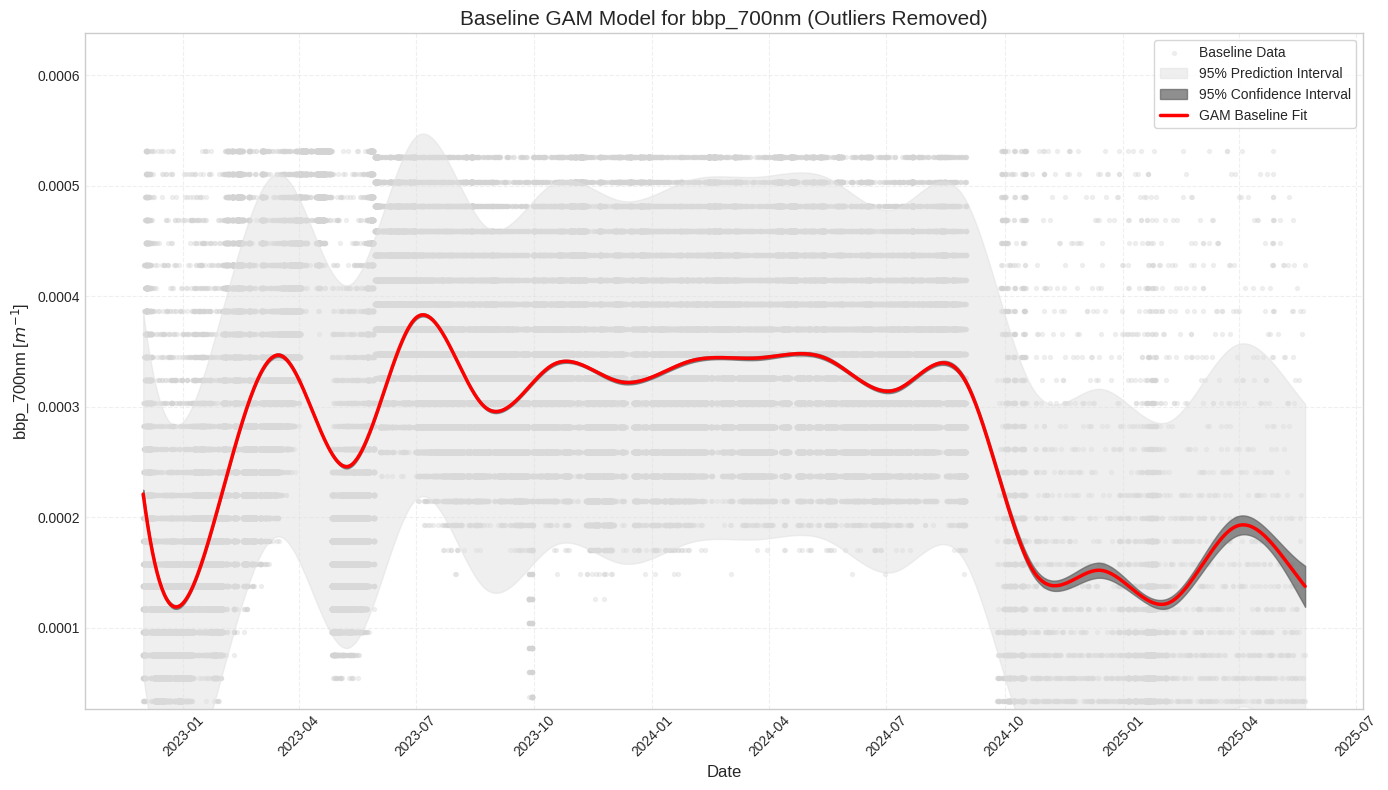

GAM model successfully fitted using cleaned data. Baseline and residuals added to full 'data' DataFrame.


In [9]:
# --- GAM Baseline Modeling ---
# Ensure pygam is imported before running this cell
try:
    from pygam import LinearGAM, s
except ImportError:
    print("LinearGAM or s not found. Make sure pygam is installed: !pip install pygam")

# We use 'data_baseline' which was created in the previous cell
if 'data_baseline' in locals() and not data_baseline.empty and bbp_col in data_baseline.columns:
    try:
        print(f"Modeling baseline for {bbp_col} using GAM...")
        
        # 1. Prepare Data: Predictor (X) must be numeric
        X = data_baseline['date'].map(datetime.timestamp).values.reshape(-1, 1)
        y = data_baseline[bbp_col].values
        
        # 2. Define and fit the GAM
        gam = LinearGAM(s(0)).fit(X, y)
        
        # 3. Predict across a continuous timeline for plotting
        X_pred = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
        y_pred = gam.predict(X_pred)
        
        # 4. Calculate Uncertainty Intervals
        conf_int = gam.confidence_intervals(X_pred, width=0.95)
        
        resids = y - gam.predict(X)
        sigma_resids = np.std(resids)
        
        se_fit = (conf_int[:, 1] - conf_int[:, 0]) / (2 * 1.96)
        se_pred = np.sqrt(se_fit**2 + sigma_resids**2)
        
        pi_low = y_pred - 1.96 * se_pred
        pi_high = y_pred + 1.96 * se_pred
        
        date_pred = [datetime.fromtimestamp(x[0]) for x in X_pred]
        
        # 5. Visualization
        plt.figure(figsize=(14, 8))
        
        # Plot data_baseline points
        plt.scatter(data_baseline['date'], data_baseline[bbp_col], color='lightgray', s=8, alpha=0.3, label='Baseline Data')
        
        # 95% Prediction Interval (Light Grey)
        plt.fill_between(date_pred, pi_low, pi_high, color='#E0E0E0', alpha=0.5, label='95% Prediction Interval')
        
        # 95% Confidence Interval (Dark Grey)
        plt.fill_between(date_pred, conf_int[:, 0], conf_int[:, 1], color='#606060', alpha=0.7, label='95% Confidence Interval')
        
        # Fit Line
        plt.plot(date_pred, y_pred, color='red', linewidth=2.5, label='GAM Baseline Fit')
        
        plt.title(f'Baseline GAM Model for {bbp_col} (Outliers Removed)', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(f'{bbp_col} [$m^{{-1}}$]', fontsize=12)
        
        y_min, y_max = np.percentile(y, [0.1, 99.9])
        plt.ylim(y_min * 0.8, y_max * 1.2)
        
        plt.legend(loc='upper right', frameon=True, fontsize=10)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # 6. Add results back to the original 'data' dataframe for full comparison
        # We need to map the GAM prediction to the original timestamps
        X_full = data['date'].map(datetime.timestamp).values.reshape(-1, 1)
        data['bbp_baseline'] = gam.predict(X_full)
        data['bbp_residuals'] = data[bbp_col] - data['bbp_baseline']

        # Store PI bounds for anomaly detection in next cell
        # Standard Error of prediction for the full dataset
        conf_int_full = gam.confidence_intervals(X_full, width=0.95)
        se_fit_full = (conf_int_full[:, 1] - conf_int_full[:, 0]) / (2 * 1.96)
        se_pred_full = np.sqrt(se_fit_full**2 + sigma_resids**2)
        
        data['pi_low'] = data['bbp_baseline'] - 1.96 * se_pred_full
        data['pi_high'] = data['bbp_baseline'] + 1.96 * se_pred_full

        
        print("GAM model successfully fitted using cleaned data. Baseline and residuals added to full 'data' DataFrame.")
        
    except Exception as e:
        print(f"Error fitting GAM: {e}")
else:
    print("No baseline data available for GAM modeling.")

### Visualizing Baseline vs. All Data Points (Anomaly Detection)

Generating anomaly plot for bbp_700nm...


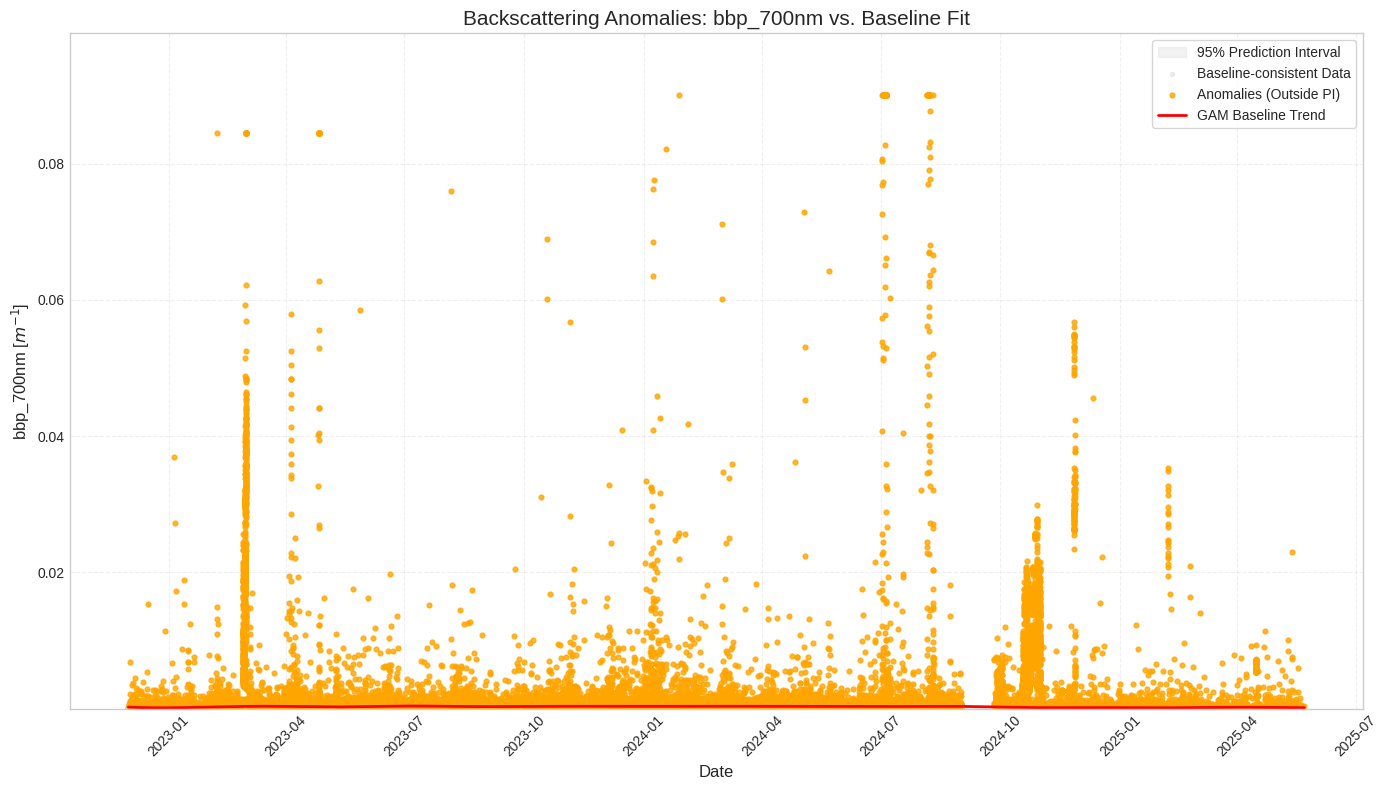

Anomaly plot generated. Total points: 191642
Anomalies detected: 37804 (19.73%)


In [10]:
# --- Anomaly Visualization with Original Data ---
if not data.empty and 'bbp_baseline' in data.columns:
    try:
        print(f"Generating anomaly plot for {bbp_col}...")
        
        # Identify outliers (points outside the 95% PI)
        # pi_high and pi_low were calculated in the previous cell for the full 'data' frame
        data['is_anomaly'] = (data[bbp_col] > data['pi_high'])
        
        # Split data for plotting
        baseline_pts = data[~data['is_anomaly']]
        anomaly_pts = data[data['is_anomaly']]
        
        # Setup Figure
        plt.figure(figsize=(14, 8))
        
        # 1. Plot Prediction Interval (Light Grey)
        # Re-sort data by date for fill_between
        plot_df = data.sort_values('date')
        plt.fill_between(plot_df['date'], plot_df['pi_low'], plot_df['pi_high'], 
                         color='#E0E0E0', alpha=0.4, label='95% Prediction Interval')
        
        # 2. Plot Baseline Data Points (Gray)
        plt.scatter(baseline_pts['date'], baseline_pts[bbp_col], 
                    color='lightgray', s=8, alpha=0.4, label='Baseline-consistent Data')
        
        # 3. Plot Anomalies (Orange)
        plt.scatter(anomaly_pts['date'], anomaly_pts[bbp_col], 
                    color='orange', s=12, alpha=0.8, label='Anomalies (Outside PI)')
        
        # 4. Plot GAM Baseline Fit (Red Line)
        plt.plot(plot_df['date'], plot_df['bbp_baseline'], 
                 color='red', linewidth=2, label='GAM Baseline Trend')
        
        # Formatting
        plt.title(f'Backscattering Anomalies: {bbp_col} vs. Baseline Fit', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(f'{bbp_col} [$m^{{-1}}$]', fontsize=12)
        
        # Set Y-axis limits based on full data range
        y_max = data[bbp_col].max()
        plt.ylim(data[bbp_col].min() * 0.8, y_max * 1.1)
        
        plt.legend(loc='upper right', frameon=True, fontsize=10)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"Anomaly plot generated. Total points: {len(data)}")
        print(f"Anomalies detected: {len(anomaly_pts)} ({len(anomaly_pts)/len(data)*100:.2f}%)")
        
    except Exception as e:
        print(f"Error generating anomaly plot: {e}")
else:
    print("Baseline model not found. Please run Section 10 first.")


### Quantifying Anomaly Proportions Relative to Pulse Events
#### This section calculates the overall proportion of anomalies and specifically how that proportion changes before, during, and after "Pulse Events" (defined as clusters of anomalous data).

In [15]:
# --- Statistical Analysis of Anomalies and Pulse Windows ---
if 'data' in locals() and 'is_anomaly' in data.columns:
    print("--- Quantifying Anomaly Proportions ---")
    
    # 1. Overall Proportion
    total_pts = len(data)
    total_anomalies = data['is_anomaly'].sum()
    overall_prop = total_anomalies / total_pts
    print(f"Overall proportion of data points outside 95% PI: {overall_prop:.2%} ({total_anomalies}/{total_pts})")

    # 2. Define "Pulse Events"
    # Pulse Event is a period of at least 30 consecutive anomalous points
    # This filters out single-point noise.
    data['pulse_group'] = (data['is_anomaly'] != data['is_anomaly'].shift()).cumsum()
    pulse_summary = data[data['is_anomaly']].groupby('pulse_group').agg(
        start_date=('date', 'min'),
        end_date=('date', 'max'),
        duration=('date', lambda x: (x.max() - x.min()).total_seconds() / 3600), # hours
        count=('is_anomaly', 'count')
    )
    
    # Keep only groups with at least 10 points to define a meaningful "event"
    significant_pulses = pulse_summary[pulse_summary['count'] >= 10].copy()
    print(f"Identified {len(significant_pulses)} significant pulse events (>= 10 consecutive anomalies).")

    # 3. Analyze Windows Before and After Pulse Events
    # We define a window of 7 days (168 hours) before and after each pulse
    window_size = pd.Timedelta(days=7)
    
    before_indices = set()
    after_indices = set()
    within_pulse_indices = set()

    for idx, pulse in significant_pulses.iterrows():
        # Points during the pulse
        pulse_mask = (data['date'] >= pulse['start_date']) & (data['date'] <= pulse['end_date'])
        within_pulse_indices.update(data.index[pulse_mask])
        
        # Points before the pulse
        before_mask = (data['date'] >= pulse['start_date'] - window_size) & (data['date'] < pulse['start_date'])
        before_indices.update(data.index[before_mask])
        
        # Points after the pulse
        after_mask = (data['date'] > pulse['end_date']) & (data['date'] <= pulse['end_date'] + window_size)
        after_indices.update(data.index[after_mask])

    # Convert sets to sorted indices
    before_indices = sorted(list(before_indices - within_pulse_indices)) # Exclude pulse points if overlapping
    after_indices = sorted(list(after_indices - within_pulse_indices))   # Exclude pulse points if overlapping
    
    # 4. Calculate Proportions
    def calc_prop(indices, label):
        if not indices:
            return 0.0, 0, 0
        subset = data.loc[indices]
        anom_count = subset['is_anomaly'].sum()
        total = len(subset)
        prop = anom_count / total
        print(f"Proportion outside PI {label}: {prop:.2%} ({anom_count}/{total})")
        return prop, anom_count, total

    print("\n--- Context-Specific Analysis ---")
    calc_prop(before_indices, "in 7-day windows BEFORE pulses")
    calc_prop(list(within_pulse_indices), "WITHIN pulse events")
    calc_prop(after_indices, "in 7-day windows AFTER pulses")
    
else:
    print("Anomalies have not been identified yet")

--- Quantifying Anomaly Proportions ---
Overall proportion of data points outside 95% PI: 19.73% (37804/191642)
Identified 351 significant pulse events (>= 10 consecutive anomalies).

--- Context-Specific Analysis ---
Proportion outside PI in 7-day windows BEFORE pulses: 13.64% (10071/73816)
Proportion outside PI WITHIN pulse events: 100.00% (20655/20655)
Proportion outside PI in 7-day windows AFTER pulses: 13.45% (10057/74762)


### Highlighting Pulse Events vs. Isolated Anomalies
#### This section creates a visualization that distinguishes between sustained pulse events (>= 500 points) and isolated anomalies. Pulse event points are colored in red, while isolated anomalies remain in orange.

Generating pulse-highlighted plot for bbp_700nm...


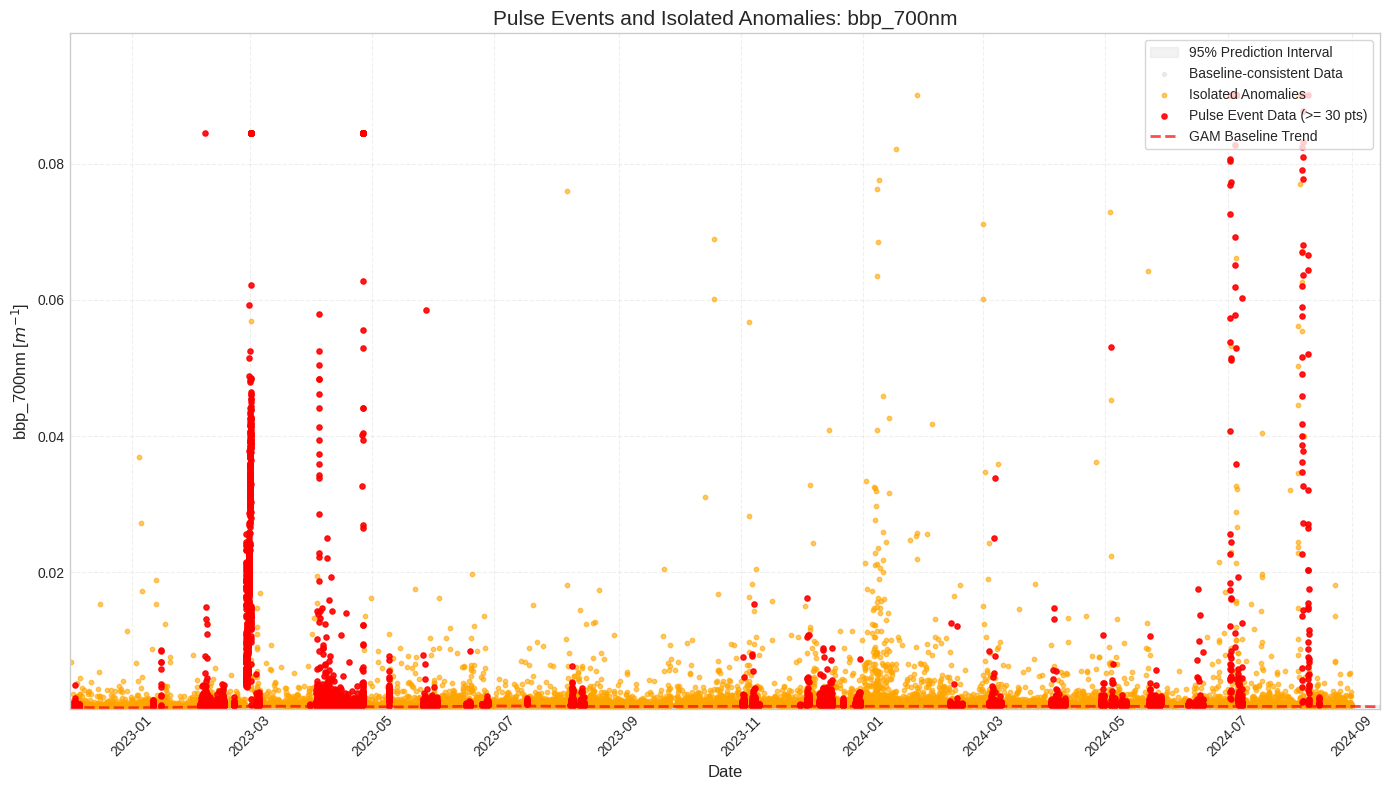

Plot generated. Pulse event points: 20655
Isolated anomaly points: 17149


In [16]:
# --- Visualizing Pulse Events vs Isolated Anomalies ---
if 'data' in locals() and 'within_pulse_indices' in locals():
    try:
        print(f"Generating pulse-highlighted plot for {bbp_col}...")
        
        # 1. Create masks based on indices identified in Section 12
        # Points that are anomalies AND part of a significant pulse (e.g. >= 30 points)
        data['is_pulse'] = data.index.isin(within_pulse_indices)
        
        # Points that are anomalies but NOT part of a significant pulse
        data['is_isolated_anomaly'] = data['is_anomaly'] & ~data['is_pulse']
        
        # 2. Split data for plotting
        baseline_pts = data[~data['is_anomaly']]
        isolated_anomaly_pts = data[data['is_isolated_anomaly']]
        pulse_pts = data[data['is_pulse']]
        
        # 3. Setup Figure
        plt.figure(figsize=(14, 8))
        
        # Plot Prediction Interval (Light Grey)
        plot_df = data.sort_values('date')
        plt.fill_between(plot_df['date'], plot_df['pi_low'], plot_df['pi_high'], 
                         color='#E0E0E0', alpha=0.4, label='95% Prediction Interval')
        
        # Plot Baseline Data Points (Gray)
        plt.scatter(baseline_pts['date'], baseline_pts[bbp_col], 
                    color='lightgray', s=8, alpha=0.4, label='Baseline-consistent Data')
        
        # Plot Isolated Anomalies (Orange)
        plt.scatter(isolated_anomaly_pts['date'], isolated_anomaly_pts[bbp_col], 
                    color='orange', s=10, alpha=0.6, label='Isolated Anomalies')
        
        # Plot Pulse Event Data Points (Red)
        plt.scatter(pulse_pts['date'], pulse_pts[bbp_col], 
                    color='red', s=14, alpha=0.9, label='Pulse Event Data (>= 30 pts)')
        
        # Plot GAM Baseline Trend (Red Line)
        plt.plot(plot_df['date'], plot_df['bbp_baseline'], 
                 color='red', linewidth=2, linestyle='--', alpha=0.7, label='GAM Baseline Trend')
        
        # Formatting
        plt.title(f'Pulse Events and Isolated Anomalies: {bbp_col}', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel(f'{bbp_col} [$m^{{-1}}$]', fontsize=12)
        
        # X- and Y-axis scaling
        start_lim = data['date'].min()
        end_lim = datetime(2024, 9, 15) 
        plt.xlim(start_lim, end_lim)

        y_max = data[bbp_col].max()
        plt.ylim(data[bbp_col].min() * 0.8, y_max * 1.1)
        
        plt.legend(loc='upper right', frameon=True, fontsize=10)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"Plot generated. Pulse event points: {len(pulse_pts)}")
        print(f"Isolated anomaly points: {len(isolated_anomaly_pts)}")
        
    except Exception as e:
        print(f"Error generating highlighted plot: {e}")
else:
    print("Pulse data has not been calculated.")


### Outlier Removal for Trap Flux Baseline
#### This section performs outlier removal on the tot_mass_flux column to prepare a baseline for sediment trap data.

In [17]:
# --- Outlier Removal for Trap Data ---
trap_col = 'tot_mass_flux'
if 'trap_flux_tbl' in locals() and not trap_flux_tbl.empty:
    print(f"Performing outlier removal for {trap_col} baseline...")
    
    # R: hi <- quantile(..., 0.85); lo <- quantile(..., 0.001)
    hi_trap = trap_flux_tbl[trap_col].quantile(0.85)
    lo_trap = trap_flux_tbl[trap_col].quantile(0.001)
    
    trap_baseline_df = trap_flux_tbl[(trap_flux_tbl[trap_col] < hi_trap) & 
                                    (trap_flux_tbl[trap_col] > lo_trap)].copy()
    
    print(f"High threshold: {hi_trap:.2f}, Low threshold: {lo_trap:.2f}")
    print(f"Cleaned row count (baseline subset): {len(trap_baseline_df)} of {len(trap_flux_tbl)}")
else:
    print("Trap flux data not found.")

Performing outlier removal for tot_mass_flux baseline...
High threshold: 489.83, Low threshold: 2.88
Cleaned row count (baseline subset): 58 of 70


### Modeling Baseline Trap Flux (GAM Translation)
#### Modeling the seasonal baseline trend for total mass flux using GAM.

In [18]:
    # --- GAM Baseline Modeling for Trap Data ---
if 'trap_baseline_df' in locals() and not trap_baseline_df.empty:
    try:
        print(f"Modeling baseline for {trap_col} using GAM...")
        
        # 1. Prepare Data: Ensure Mid-Date is datetime and convert to numeric timestamp
        # Converting to int64 nanoseconds then dividing for seconds since epoch
        trap_baseline_df['Mid-Date'] = pd.to_datetime(trap_baseline_df['Mid-Date'])
        X_t = trap_baseline_df['Mid-Date'].values.astype(np.int64) // 10**9
        X_t = X_t.reshape(-1, 1)
        y_t = trap_baseline_df[trap_col].values
        
        # 2. Fit GAM
        gam_trap = LinearGAM(s(0)).fit(X_t, y_t)
        
        # 3. Add results back to full trap_flux_tbl
        trap_flux_tbl['Mid-Date'] = pd.to_datetime(trap_flux_tbl['Mid-Date'])
        X_t_full = trap_flux_tbl['Mid-Date'].values.astype(np.int64) // 10**9
        X_t_full = X_t_full.reshape(-1, 1)
        trap_flux_tbl['baseline'] = gam_trap.predict(X_t_full)
        
        # 4. Uncertainty Envelopes
        conf_int_t = gam_trap.confidence_intervals(X_t_full, width=0.95)
        sigma_res_t = np.std(y_t - gam_trap.predict(X_t))
        se_fit_t = (conf_int_t[:, 1] - conf_int_t[:, 0]) / (2 * 1.96)
        se_pred_t = np.sqrt(se_fit_t**2 + sigma_res_t**2)
        
        trap_flux_tbl['pi_low'] = trap_flux_tbl['baseline'] - 1.96 * se_pred_t
        trap_flux_tbl['pi_high'] = trap_flux_tbl['baseline'] + 1.96 * se_pred_t
        
        print("GAM model for trap flux successfully fitted.")
        
    except Exception as e:
        print(f"Error fitting GAM for trap data: {e}")


Modeling baseline for tot_mass_flux using GAM...
GAM model for trap flux successfully fitted.


### Visualizing Trap Baseline Anomaly Detection
#### Plotting all sediment trap mass flux points and highlighting anomalies falling outside the prediction interval.

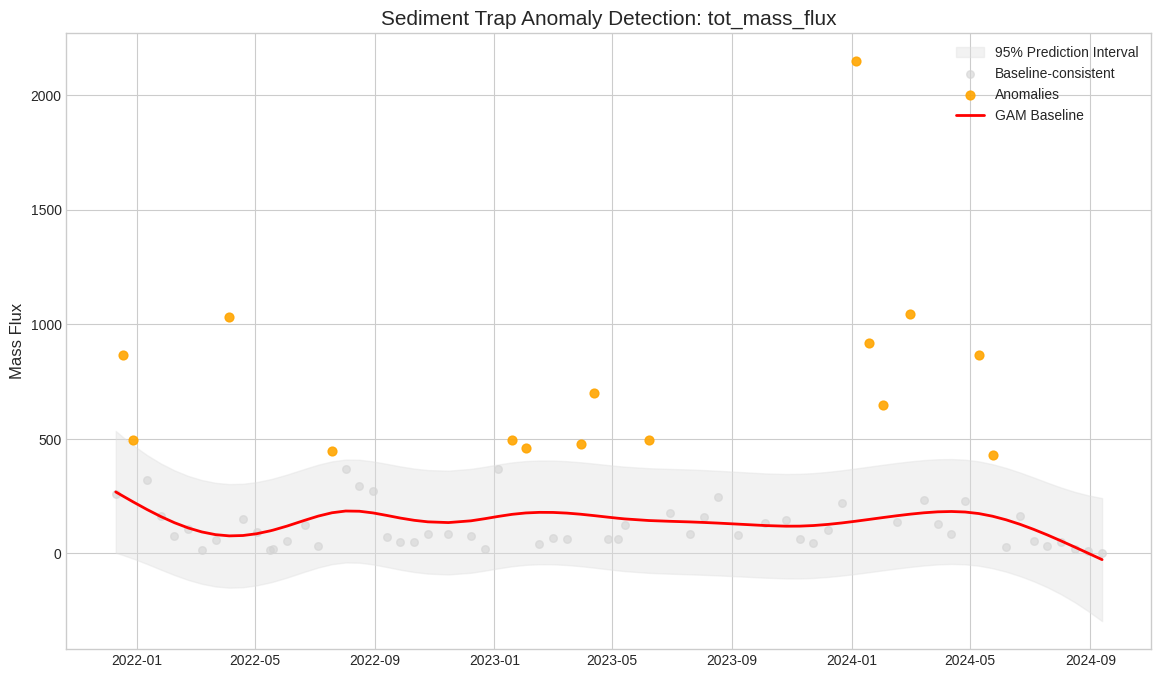

In [19]:
# --- Anomaly Visualization for Trap Data ---
if 'trap_flux_tbl' in locals() and 'baseline' in trap_flux_tbl.columns:
    trap_flux_tbl['is_anomaly'] = (trap_flux_tbl[trap_col] > trap_flux_tbl['pi_high']) | \
                                  (trap_flux_tbl[trap_col] < trap_flux_tbl['pi_low'])
    
    plt.figure(figsize=(14, 8))
    df_sorted = trap_flux_tbl.sort_values('Mid-Date')
    
    # Envelopes
    plt.fill_between(df_sorted['Mid-Date'], df_sorted['pi_low'], df_sorted['pi_high'], 
                     color='#E0E0E0', alpha=0.4, label='95% Prediction Interval')
    
    # Points
    norm_pts = trap_flux_tbl[~trap_flux_tbl['is_anomaly']]
    anom_pts = trap_flux_tbl[trap_flux_tbl['is_anomaly']]
    
    plt.scatter(norm_pts['Mid-Date'], norm_pts[trap_col], color='lightgray', s=30, alpha=0.6, label='Baseline-consistent')
    plt.scatter(anom_pts['Mid-Date'], anom_pts[trap_col], color='orange', s=40, alpha=0.9, label='Anomalies')
    
    # Fit
    plt.plot(df_sorted['Mid-Date'], df_sorted['baseline'], color='red', linewidth=2, label='GAM Baseline')
    
    plt.title(f'Sediment Trap Anomaly Detection: {trap_col}', fontsize=15)
    plt.ylabel('Mass Flux', fontsize=12)
    plt.legend()
    plt.show()

### Quantifying Trap Anomaly Proportions
#### Calculating proportions relative to pulse events for the sediment trap data.

In [20]:
# --- Statistical Analysis for Trap Data ---
if 'trap_flux_tbl' in locals() and 'is_anomaly' in trap_flux_tbl.columns:
    total_t = len(trap_flux_tbl)
    anom_t = trap_flux_tbl['is_anomaly'].sum()
    print(f"Overall proportion outside 95% PI: {anom_t/total_t:.2%}")
    
    # Define Pulse: For low-freq traps, we use 3 consecutive points
    trap_flux_tbl['pulse_group'] = (trap_flux_tbl['is_anomaly'] != trap_flux_tbl['is_anomaly'].shift()).cumsum()
    p_sum = trap_flux_tbl[trap_flux_tbl['is_anomaly']].groupby('pulse_group').agg(
        start_date=('Mid-Date', 'min'), end_date=('Mid-Date', 'max'), count=('is_anomaly', 'count')
    )
    sig_p_trap = p_sum[p_sum['count'] >= 2] # Adjusted threshold for low frequency
    print(f"Identified {len(sig_p_trap)} pulse events (>= 2 consecutive points).")

Overall proportion outside 95% PI: 21.43%
Identified 5 pulse events (>= 2 consecutive points).


### Highlighting Trap Pulse Events vs. Isolated Anomalies
#### Highlighting sustained flux events in red on the sediment trap timeline.

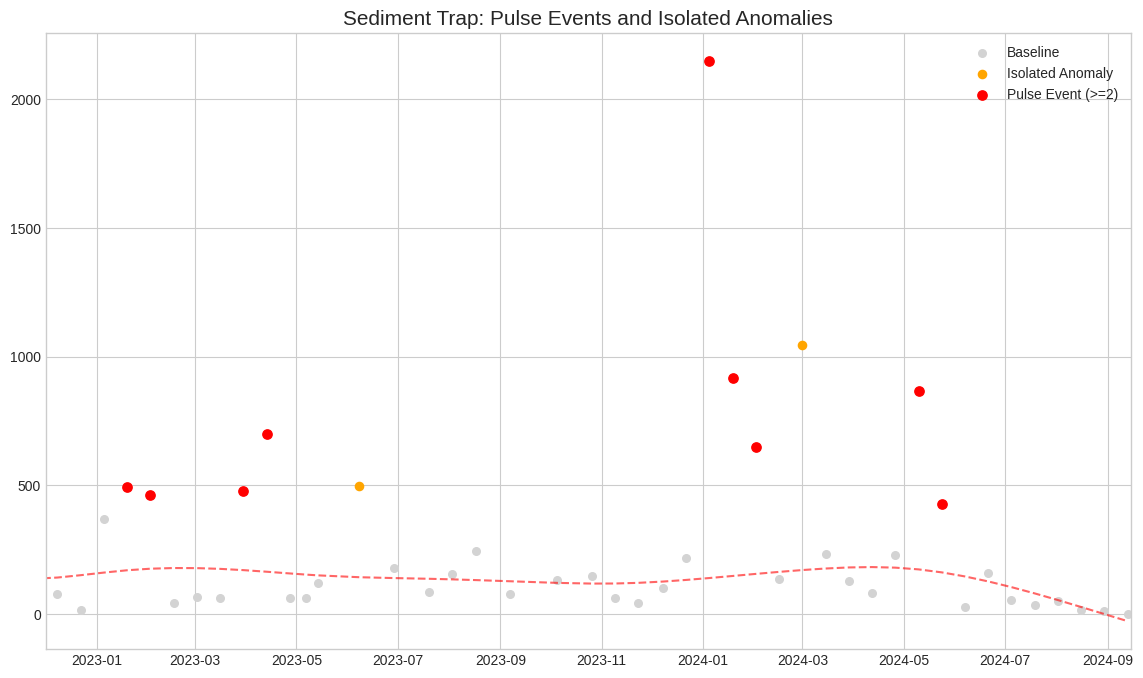

In [21]:
# --- Pulse Highlighting for Trap Data ---
if 'sig_p_trap' in locals():
    # Identify indices
    pulse_indices = set()
    for _, p in sig_p_trap.iterrows():
        mask = (trap_flux_tbl['Mid-Date'] >= p['start_date']) & (trap_flux_tbl['Mid-Date'] <= p['end_date'])
        pulse_indices.update(trap_flux_tbl.index[mask])
    
    trap_flux_tbl['is_pulse'] = trap_flux_tbl.index.isin(pulse_indices)
    
    plt.figure(figsize=(14, 8))
    plt.scatter(trap_flux_tbl[~trap_flux_tbl['is_anomaly']]['Mid-Date'], 
                trap_flux_tbl[~trap_flux_tbl['is_anomaly']][trap_col], color='lightgray', s=30, label='Baseline')
    plt.scatter(trap_flux_tbl[trap_flux_tbl['is_anomaly'] & ~trap_flux_tbl['is_pulse']]['Mid-Date'], 
                trap_flux_tbl[trap_flux_tbl['is_anomaly'] & ~trap_flux_tbl['is_pulse']][trap_col], color='orange', s=35, label='Isolated Anomaly')
    plt.scatter(trap_flux_tbl[trap_flux_tbl['is_pulse']]['Mid-Date'], 
                trap_flux_tbl[trap_flux_tbl['is_pulse']][trap_col], color='red', s=45, label='Pulse Event (>=2)')
    
    plt.plot(trap_flux_tbl.sort_values('Mid-Date')['Mid-Date'], 
             trap_flux_tbl.sort_values('Mid-Date')['baseline'], color='red', linestyle='--', alpha=0.6)
    
    # X-axis scaling
    start_lim = datetime(2022, 12, 1) 
    end_lim = datetime(2024, 9, 15) 
    plt.xlim(start_lim, end_lim)
    
    plt.title('Sediment Trap: Pulse Events and Isolated Anomalies', fontsize=15)
    plt.legend()
    plt.show()

### Bbp AUC Calculation

Calculating 2-day integrated AUC for bbp_700nm...
AUC calculation complete.
  Period_Start  Bbp_AUC_2day
0   2022-12-01      0.000366
1   2022-12-03      0.000728
2   2022-12-05      0.000492
3   2022-12-07      0.000355
4   2022-12-09      0.000258
5   2022-12-11      0.000234
6   2022-12-13      0.000259
7   2022-12-15      0.000682
8   2022-12-17      0.000216
9   2022-12-19      0.000272


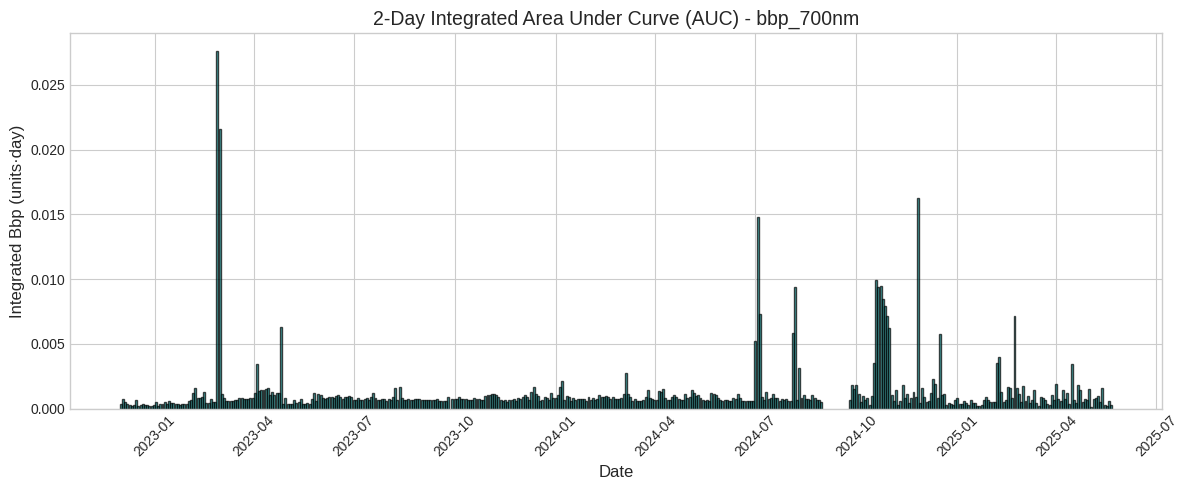

Performing outlier removal for bbp_700nm AUC baseline...
High threshold (85th percentile): 0.001242
Low threshold (0.1st percentile): 0.000177
Original AUC row count: 452
Cleaned AUC row count (baseline subset): 372
Removed 80 AUC outliers.


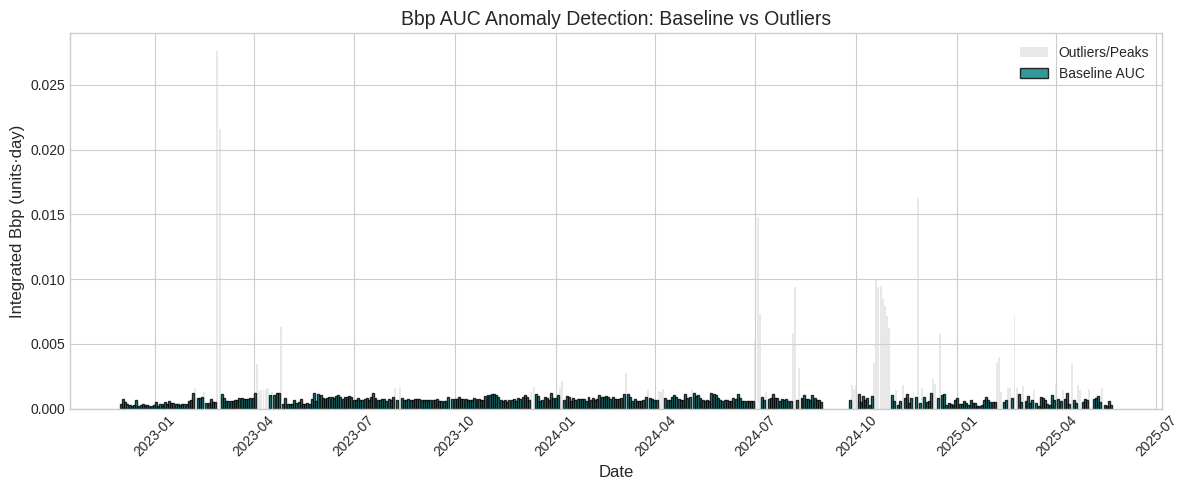

In [27]:
# --- Calculate Bbp AUC Integrated over a selected number of days ---
if not data.empty and bbp_col in data.columns:
    # Defining 'X' as 2 for consistency with the 2-day resampling window
    print(f"Calculating 2-day integrated AUC for {bbp_col}...")
    
    # Ensure data is sorted by date
    data_auc = data.sort_values('date').copy()
    
    # 1. Set 'date' as index for time-series resampling
    data_auc.set_index('date', inplace=True)
    
    # 2. Calculate AUC using trapezoidal integration
    # We resample to X-day windows (e.g. '2D' as specified in the logic). 
    # np.trapz requires numeric x-coordinates; we convert timestamps to days.
    def calculate_trapz(group):
        if len(group) < 2:
            return np.nan
        # Convert index to days relative to the start of the group
        x = (group.index - group.index[0]).total_seconds() / (24 * 3600)
        y = group[bbp_col].values
        return np.trapz(y, x)

    # Apply integration over resampled windows
    # Here we use resample to align with the specified window
    bbp_auc_Xd = data_auc.resample('2D').apply(calculate_trapz)
    
    # 3. Create a summary DataFrame
    bbp_auc_summary = bbp_auc_Xd.reset_index()
    bbp_auc_summary.columns = ['Period_Start', 'Bbp_AUC_2day']
    
    print("AUC calculation complete.")
    print(bbp_auc_summary.head(10))
    
    # Visualization of AUC
    plt.figure(figsize=(12, 5))
    plt.bar(bbp_auc_summary['Period_Start'], bbp_auc_summary['Bbp_AUC_2day'], 
            width=1.8, color='teal', alpha=0.7, edgecolor='black')
    plt.title(f'2-Day Integrated Area Under Curve (AUC) - {bbp_col}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Integrated Bbp (units·day)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for AUC calculation.")

# --- Outlier Removal via Quantiles for AUC Baseline ---
if 'bbp_auc_summary' in locals() and not bbp_auc_summary.empty:
    print(f"Performing outlier removal for {bbp_col} AUC baseline...")
    
    auc_col = 'Bbp_AUC_2day'
    
    # Calculate thresholds on the AUC values
    hi = bbp_auc_summary[auc_col].quantile(0.85)
    lo = bbp_auc_summary[auc_col].quantile(0.001)
    
    print(f"High threshold (85th percentile): {hi:.6f}")
    print(f"Low threshold (0.1st percentile): {lo:.6f}")
    
    initial_count = len(bbp_auc_summary)
    # Filter AUC data points that fall within the baseline quantile range
    bbp_auc_clean = bbp_auc_summary[(bbp_auc_summary[auc_col] < hi) & 
                                    (bbp_auc_summary[auc_col] > lo)].copy()
    
    print(f"Original AUC row count: {initial_count}")
    print(f"Cleaned AUC row count (baseline subset): {len(bbp_auc_clean)}")
    print(f"Removed {initial_count - len(bbp_auc_clean)} AUC outliers.")
    
    # Visualization of Outliers vs Baseline
    plt.figure(figsize=(12, 5))
    
    # Plot all points in light gray
    plt.bar(bbp_auc_summary['Period_Start'], bbp_auc_summary[auc_col], 
            width=1.8, color='lightgray', alpha=0.5, label='Outliers/Peaks')
    
    # Overlay cleaned baseline in teal
    plt.bar(bbp_auc_clean['Period_Start'], bbp_auc_clean[auc_col], 
            width=1.8, color='teal', alpha=0.8, edgecolor='black', label='Baseline AUC')
    
    plt.title(f'Bbp AUC Anomaly Detection: Baseline vs Outliers', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Integrated Bbp (units·day)', fontsize=12)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Define specific dataframe for baseline AUC modeling
    data_auc_baseline = bbp_auc_clean
else:
    print("No AUC summary data available for outlier removal.")

### Modeling Baseline Bbp AUC (GAM Translation)

Modeling baseline for 2-day integrated AUC using GAM...


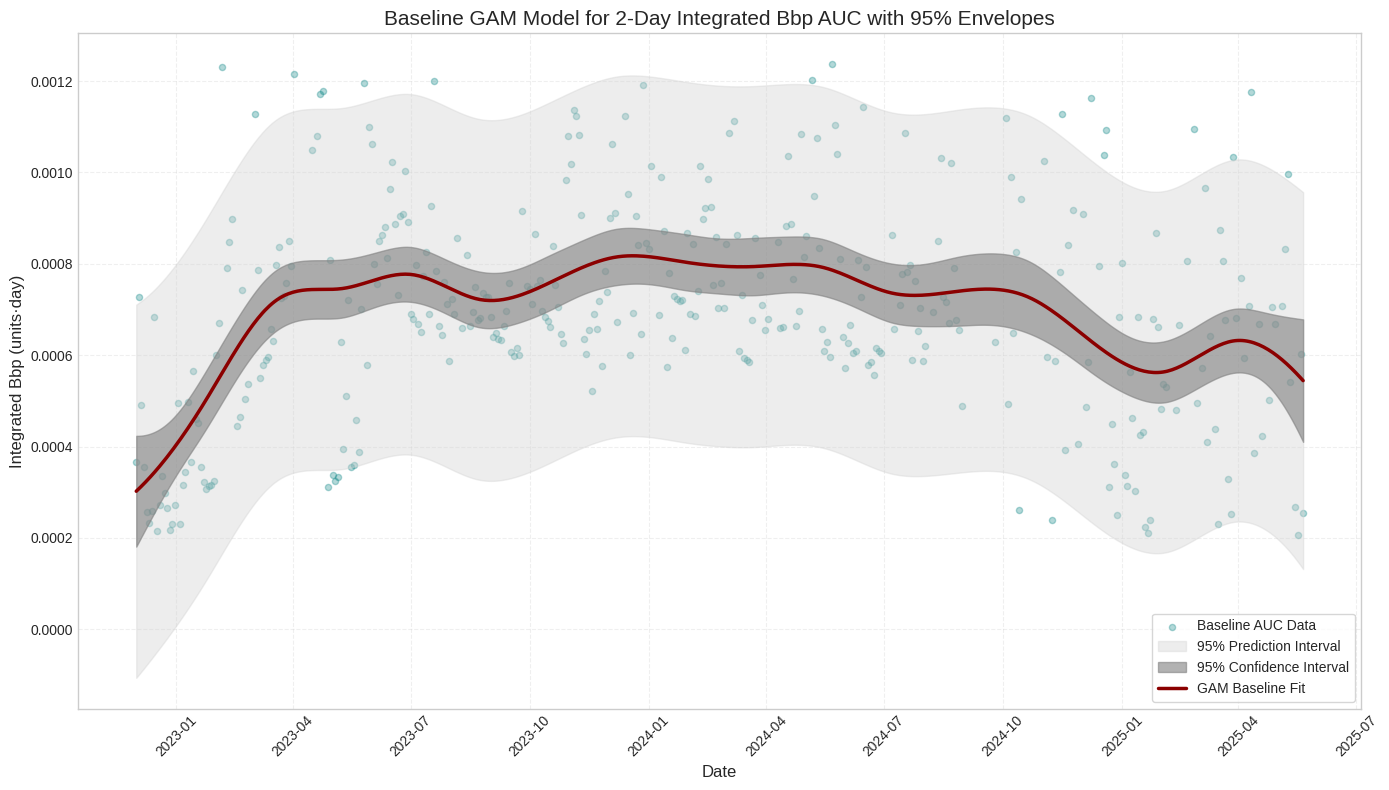

GAM model successfully fitted to AUC baseline data.


In [30]:
try:
    from pygam import LinearGAM, s
except ImportError:
    print("LinearGAM or s not found. Make sure pygam is installed: !pip install pygam")

if 'bbp_auc_clean' in locals() and not bbp_auc_clean.empty:
    try:
        print("Modeling baseline for 2-day integrated AUC using GAM...")
        
        # 1. Prepare Data
        # X: Convert Period_Start to numeric timestamp (seconds since epoch)
        X_auc = bbp_auc_clean['Period_Start'].map(datetime.timestamp).values.reshape(-1, 1)
        y_auc = bbp_auc_clean['Bbp_AUC_2day'].values
        
        # 2. Define and fit the GAM
        # Using a spline term to capture the smooth baseline trend
        gam_auc = LinearGAM(s(0)).fit(X_auc, y_auc)
        
        # 3. Predict across a continuous timeline for plotting
        X_auc_pred = np.linspace(X_auc.min(), X_auc.max(), 500).reshape(-1, 1)
        y_auc_pred = gam_auc.predict(X_auc_pred)
        
        # 4. Calculate Uncertainty Intervals
        # Confidence Interval (CI) of the mean fit (95%)
        conf_int_auc = gam_auc.confidence_intervals(X_auc_pred, width=0.95)
        
        # Prediction Interval (PI) of the observations (95%)
        # PI accounts for the variance of the fit AND the variance of the noise (residuals)
        resids = y_auc - gam_auc.predict(X_auc)
        sigma_resids = np.std(resids)
        
        # SE of fit can be approximated from the width of the confidence interval
        # (upper - lower) / (2 * 1.96) = SE_fit (approx)
        se_fit = (conf_int_auc[:, 1] - conf_int_auc[:, 0]) / (2 * 1.96)
        se_pred = np.sqrt(se_fit**2 + sigma_resids**2)
        
        pi_low = y_auc_pred - 1.96 * se_pred
        pi_high = y_auc_pred + 1.96 * se_pred
        
        # Convert numeric prediction dates back to datetime
        date_auc_pred = [datetime.fromtimestamp(x[0]) for x in X_auc_pred]
        
        # 5. Visualization
        plt.figure(figsize=(14, 8))
        
        # Raw Baseline Data
        plt.scatter(bbp_auc_clean['Period_Start'], bbp_auc_clean['Bbp_AUC_2day'], 
                    color='teal', s=20, alpha=0.3, label='Baseline AUC Data')
        
        # 95% Prediction Interval (Light Grey)
        plt.fill_between(date_auc_pred, pi_low, pi_high, 
                         color='lightgray', alpha=0.4, label='95% Prediction Interval')
        
        # 95% Confidence Interval (Dark Grey - uncertainty in the mean)
        plt.fill_between(date_auc_pred, conf_int_auc[:, 0], conf_int_auc[:, 1], 
                         color='gray', alpha=0.6, label='95% Confidence Interval')
        
        # GAM Fit line
        plt.plot(date_auc_pred, y_auc_pred, color='darkred', linewidth=2.5, label='GAM Baseline Fit')
        
        plt.title('Baseline GAM Model for 2-Day Integrated Bbp AUC with 95% Envelopes', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Integrated Bbp (units·day)', fontsize=12)
        plt.legend(loc='best', frameon=True)
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # 6. Map baseline back to the full summary for residual calculation
        X_auc_all = bbp_auc_summary['Period_Start'].map(datetime.timestamp).values.reshape(-1, 1)
        bbp_auc_summary['AUC_Baseline'] = gam_auc.predict(X_auc_all)
        bbp_auc_summary['AUC_Residuals'] = bbp_auc_summary['Bbp_AUC_2day'] - bbp_auc_summary['AUC_Baseline']
        
        # Standard Error of prediction for anomaly detection
        conf_int_full = gam_auc.confidence_intervals(X_auc_all, width=0.95)
        se_fit_full = (conf_int_full[:, 1] - conf_int_full[:, 0]) / (2 * 1.96)
        se_pred_full = np.sqrt(se_fit_full**2 + sigma_resids**2)
        
        bbp_auc_summary['pi_low'] = bbp_auc_summary['AUC_Baseline'] - 1.96 * se_pred_full
        bbp_auc_summary['pi_high'] = bbp_auc_summary['AUC_Baseline'] + 1.96 * se_pred_full
        
        print("GAM model successfully fitted to AUC baseline data.")
        
    except Exception as e:
        print(f"Error fitting GAM for AUC: {e}")
else:
    print("No cleaned AUC data available for modeling.")

### Visualizing Bbp AUC Anomaly Detection
#### This section identifies anomalies in the 2-day integrated AUC data based on the GAM baseline and prediction intervals, highlighting points that fall outside the expected baseline range.

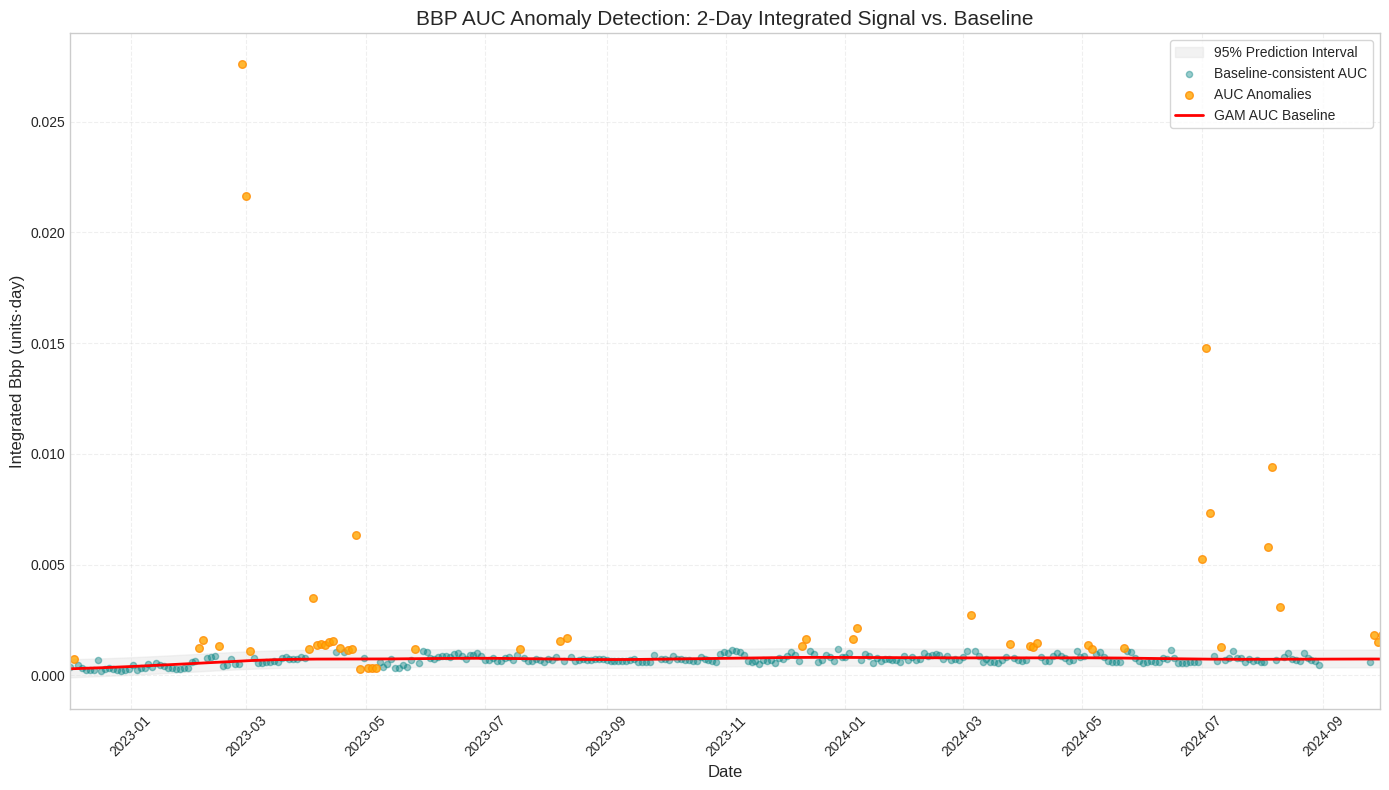

Total AUC windows analyzed: 452
Anomalies detected: 91 (20.13%)


In [32]:
if 'bbp_auc_summary' in locals() and 'AUC_Baseline' in bbp_auc_summary.columns:
    # Identify anomalies
    bbp_auc_summary['is_anomaly'] = (bbp_auc_summary['Bbp_AUC_2day'] > bbp_auc_summary['pi_high']) | \
                                    (bbp_auc_summary['Bbp_AUC_2day'] < bbp_auc_summary['pi_low'])
    
    # Split for plotting
    baseline_pts = bbp_auc_summary[~bbp_auc_summary['is_anomaly']]
    anomaly_pts = bbp_auc_summary[bbp_auc_summary['is_anomaly']]
    
    plt.figure(figsize=(14, 8))
    
    # Plot Prediction Interval (shaded region)
    plt.fill_between(bbp_auc_summary['Period_Start'], bbp_auc_summary['pi_low'], bbp_auc_summary['pi_high'], 
                     color='#E0E0E0', alpha=0.4, label='95% Prediction Interval')
    
    # Plot Baseline Data Points (points within PI)
    plt.scatter(baseline_pts['Period_Start'], baseline_pts['Bbp_AUC_2day'], 
                color='teal', s=20, alpha=0.4, label='Baseline-consistent AUC')
    
    # Plot Anomalies (points outside PI)
    plt.scatter(anomaly_pts['Period_Start'], anomaly_pts['Bbp_AUC_2day'], 
                color='orange', s=30, alpha=0.8, edgecolor='darkorange', label='AUC Anomalies')
    
    # Plot GAM Baseline Trend
    plt.plot(bbp_auc_summary['Period_Start'], bbp_auc_summary['AUC_Baseline'], 
             color='red', linewidth=2, label='GAM AUC Baseline')
    
    # Formatting
    plt.title('BBP AUC Anomaly Detection: 2-Day Integrated Signal vs. Baseline', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Integrated Bbp (units·day)', fontsize=12)
    
    # Set X-axis range to cover deployment
    start_lim = bbp_auc_summary['Period_Start'].min()
    end_lim = datetime(2024, 9, 30) 
    plt.xlim(start_lim, end_lim)
    
    plt.legend(loc='upper right', frameon=True, fontsize=10)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Total AUC windows analyzed: {len(bbp_auc_summary)}")
    print(f"Anomalies detected: {len(anomaly_pts)} ({len(anomaly_pts)/len(bbp_auc_summary)*100:.2f}%)")
else:
    print("AUC modeling results not found. Please run Section 20 first.")